<a href="https://colab.research.google.com/github/satrfall6/GAN_LLD_32x32/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils


In [2]:
#check if GPU is working 
torch.cuda.is_available()

True

In [3]:
#set the GPU device, then we can apply for the parameters below
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

1


In [0]:
# Batch size during training
batch_size = 64
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28
# Number of training epochs
num_epochs = 30
# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf =128
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Learning rate for optimizers
lr = 0.0002

In [0]:
# Image loading and processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5,], [0.5,])])

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform= transform,
                                    
    download=False,
)

trainLoader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [0]:
#plot 64(8*8) images in one plot
def showImages(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
#initialize weights 'CONV' and 'Batch' by normal distribution with(mean,std) 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1., 0.02)
        m.bias.data.fill_(0.)


In [0]:
#generator

class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
            )
        
            # forward method
    def forward(self, input):

        return self.main(input)

In [0]:
#discriminator
   
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.4, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.8, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

            # forward method
    def forward(self, input):
        return self.main(input)

In [0]:
#save the model
G=generator()
D=discriminator()

#set the loss function
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = opt.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = opt.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

#just for tracing the performance of model
img_list = []
G_losses = []
D_losses = []
iters = 0

In [9]:
# set model to GPU
D.cuda()
G.cuda()


generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [10]:
#apply initialize weights
G.apply(weights_init)
D.apply(weights_init)


discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.4, inplace)
    (5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.8, inplace)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [0]:
#apply saved weights
stateG_MNIST=torch.load('/content/mnist/G_MNIST')
G.load_state_dict(stateG_MNIST['state_dict'])
optimizerG.load_state_dict(stateG_MNIST['optimizer'])

stateD_MNIST=torch.load('/content/mnist/D_MNIST')
D.load_state_dict(stateD_MNIST['state_dict'])
optimizerD.load_state_dict(stateD_MNIST['optimizer'])

In [0]:
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainLoader, 0):
#        X, _ = data #just for debugging
        '''
        ###########################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ### Train with all-real batch
        '''
        # Firstly, have to set grad to zero
        D.zero_grad()
        ## Format batch
        #Take only image without the label from MNIST	
        real_img = data[0].to(device) 
        # Set the batch size same as the image batch size we input every time
        #sometimes it would not be same as the setting at original e.g.64, 60000/64 will left 32)
        b_size = real_img.size(0)
        # Create the label for images from true dataset   
        one_label = torch.full((b_size,), real_label).to(device)  
        # Forward pass real batch through D
        output = D(real_img).view(-1).to(device) 
        # Calculate loss on all-real batch
        errD_real = criterion(output, one_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        '''
        ###################################
        ## Train D with all-fake batch
        ###################################
        '''                

        # Generate batch of latent vectors(100-vector)
        noise = torch.randn(b_size, nz, 1, 1).to(device) 
        # Generate fake image batch with G
        fake = G(noise)

        zero_label = torch.full((b_size,), fake_label).to(device) 
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1).to(device) 
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, zero_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
     
        ########### for statistics ############
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        #######################################
        
        # Update D
        optimizerD.step()
        '''
        ###########################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        '''
        G.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D

        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, one_label)
        # Calculate gradients for G
        errG.backward()
        
        ########### for statistics ############
        D_G_z2 = output.mean().item()
        #######################################
        
        # Update G
        optimizerG.step()
        
        '''
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        '''
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainLoader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1  
        
        if epoch+1 % 5==0:
            samples = fake.detach()
            samples = samples.view(samples.size(0), 1, 28, 28)
            showImgs(samples)

            stateG_MNIST = {
                'epoch': epoch,
                'state_dict': G.state_dict(),
                'optimizer': optimizerG.state_dict(),

            }
            torch.save(stateG_MNIST, '/content/mnist/G_MNIST') 
            stateD_MNIST = {
                'epoch': epoch,
                'state_dict': D.state_dict(),
                'optimizer': optimizerD.state_dict(),

            }
            torch.save(stateD_MNIST, '/content/mnist/D_MNIST')

In [39]:
#save weight manually

stateG_MNIST = {
    'epoch': epoch,
    'state_dict': G.state_dict(),
    'optimizer': optimizerG.state_dict(),

}
torch.save(stateG_MNIST, '/content/mnist/G_MNIST') 
stateD_MNIST = {
    'epoch': epoch,
    'state_dict': D.state_dict(),
    'optimizer': optimizerD.state_dict(),

}
torch.save(stateD_MNIST, '/content/mnist/D_MNIST')

print("saved successfully")

saved successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


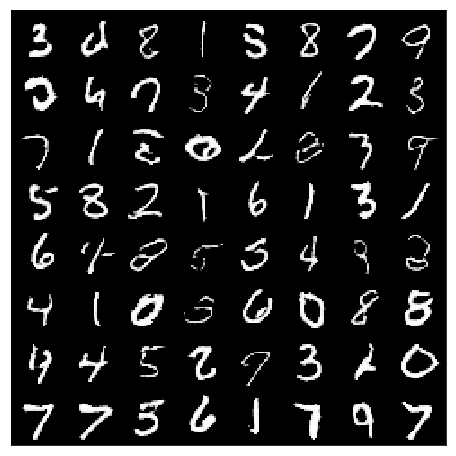

In [40]:
#manully plot
samples = fake.detach()
samples = samples.view(samples.size(0), 1, 28, 28)
showImgs(samples)

In [44]:
!git remote add origin https://github.com/satrfall6/GAN_with_icons_32x32.git
!git push -u origin master

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
